# STATGR 5432 Proejct 1: Happy Moments EDA

### For this project, the below notebook attempts to analyze how happy moments can be grouped together based on Topic Modelling and Clustering Analysis

#### Additional analysis will detail word embeddings, time permitting.

## Import data and use basic functions to examine what the data frames look like. 

In [1]:
import pandas as pd


In [2]:
df = pd.DataFrame(pd.read_csv('/Users/matthewvitha/Downloads/cleaned_hm.csv'))

In [3]:
df_sense = pd.DataFrame(pd.read_csv('/Users/matthewvitha/Downloads/senselabel (2).csv'))

In [4]:
print(df_sense.shape)
df_sense.head(2)

(2017463, 8)


,hmid,tokenOffset,word,lowercaseLemma,POS,MWE,offsetParent,supersenseLabel
0,31526,1,I,i,PRON,O,0,NaN
1,31526,2,found,find,VERB,O,0,v.cognition


In [5]:
df_sense['supersenseLabel'].unique()


array([nan, 'v.cognition', 'n.artifact', 'v.stative', 'n.substance',
       'n.food', 'n.location', 'n.communication', 'v.motion', 'n.time',
       'n.person', 'n.event', 'v.communication', 'v.social', 'n.group',
       'n.cognition', 'v.possession', 'n.state', 'v.emotion',
       'n.quantity', 'n.act', 'v.perception', 'v.change', 'v.consumption',
       'n.possession', 'n.body', 'v.contact', 'n.relation', 'n.attribute',
       'n.feeling', 'n.phenomenon', 'n.process', 'v.competition',
       'v.creation', 'v.body', 'n.animal', 'n.natural_object', 'n.motive',
       'n.plant', 'v.weather', 'n.shape', 'n.other'], dtype=object)

In [6]:
df_demo = pd.DataFrame(pd.read_csv('/Users/matthewvitha/Downloads/demographic (1).csv'))

In [7]:
print(df_demo.shape)
df_demo.head(2)

(10844, 6)


,wid,age,country,gender,marital,parenthood
0,1,37.0,USA,m,married,y
1,2,29.0,IND,m,married,y


In [8]:
df_vad = pd.DataFrame(pd.read_csv('/Users/matthewvitha/Downloads/vad.csv'))

In [9]:
print(df_vad.shape)
df_vad.head(2)

(100535, 4)


,hmid,valency,dominance,arousal
0,31526,6.614000,5.840000,3.750000
1,37050,5.663158,5.461579,3.983947


In [10]:
df.head(4)
df_small = df[0:10000]

In [11]:
df.shape

(100535, 9)

In [80]:
df.head(4)

,hmid,wid,reflection_period,original_hm,cleaned_hm,modified,num_sentence,ground_truth_category,predicted_category
0,27673,2053,24h,I went on a successful date with someone I fel...,went successful date someone felt sympathy con...,True,1,NaN,affection
1,27674,2,24h,I was happy when my son got 90% marks in his e...,happy son got 90 marks examination,True,1,NaN,affection
2,27675,1936,24h,I went to the gym this morning and did yoga.,went gym morning yoga,True,1,NaN,exercise
3,27676,206,24h,We had a serious talk with some friends of our...,serious talk friends flaky lately understood g...,True,2,bonding,bonding


## The cleaned_hm column will be the primary column of interest in the main dataset. This contains the edited happy moments 

In [13]:
df["cleaned_hm"].head()

0    I went on a successful date with someone I fel...
1    I was happy when my son got 90% marks in his e...
2         I went to the gym this morning and did yoga.
3    We had a serious talk with some friends of our...
4    I went with grandchildren to butterfly display...
Name: cleaned_hm, dtype: object

## Given that we will be using topic models to identify latent similarities between HM's, predicted categories will be important to analyze

## QUESTION: SHOULD I TRY TO USE THESE IN CLASSIFICATION PROBLEM? 

In [14]:
df["predicted_category"].value_counts()

affection           34168
achievement         33993
enjoy_the_moment    11144
bonding             10727
leisure              7458
nature               1843
exercise             1202
Name: predicted_category, dtype: int64

## As is typical with NLP projects, the below cells outline pre-processing steps. 

## Below cell makes all words in cleaned_hm column lower case.

In [15]:
import string
df['cleaned_hm'] = [i.lower() for i in df['cleaned_hm']]
#new_list = [expression(i) for i in old_list if filter(i)]

In [16]:
(df['cleaned_hm']).head(3)

0    i went on a successful date with someone i fel...
1    i was happy when my son got 90% marks in his e...
2         i went to the gym this morning and did yoga.
Name: cleaned_hm, dtype: object

## Below cell removes punctuation from cleaned_hm column 

In [17]:
df['cleaned_hm'] = [i.translate(string.punctuation) for i in df['cleaned_hm']]

In [18]:
df.head(3)

,hmid,wid,reflection_period,original_hm,cleaned_hm,modified,num_sentence,ground_truth_category,predicted_category
0,27673,2053,24h,I went on a successful date with someone I fel...,i went on a successful date with someone i fel...,True,1,NaN,affection
1,27674,2,24h,I was happy when my son got 90% marks in his e...,i was happy when my son got 90% marks in his e...,True,1,NaN,affection
2,27675,1936,24h,I went to the gym this morning and did yoga.,i went to the gym this morning and did yoga.,True,1,NaN,exercise


## The below function is defined to perform more preprocessing steps. Most notably, the words are tokenized using the regextokenizer from NLTK, and stop words are removed from the cells (also using NLTK)

In [19]:

import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
import re

def preprocess(sentence):
	sentence = sentence.lower()
	tokenizer = RegexpTokenizer(r'\w+')
	tokens = tokenizer.tokenize(sentence)
	filtered_words = [w for w in tokens if not w in stopwords.words('english')]
	return " ".join(filtered_words)

/Users/matthewvitha/anaconda/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/matthewvitha/anaconda/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/matthewvitha/anaconda/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [20]:
df_small['cleaned_hm'] = [preprocess(x) for x in df_small['cleaned_hm']]

/Users/matthewvitha/anaconda/lib/python3.5/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [21]:
df_small.head(5)

,hmid,wid,reflection_period,original_hm,cleaned_hm,modified,num_sentence,ground_truth_category,predicted_category
0,27673,2053,24h,I went on a successful date with someone I fel...,went successful date someone felt sympathy con...,True,1,NaN,affection
1,27674,2,24h,I was happy when my son got 90% marks in his e...,happy son got 90 marks examination,True,1,NaN,affection
2,27675,1936,24h,I went to the gym this morning and did yoga.,went gym morning yoga,True,1,NaN,exercise
3,27676,206,24h,We had a serious talk with some friends of our...,serious talk friends flaky lately understood g...,True,2,bonding,bonding
4,27677,6227,24h,I went with grandchildren to butterfly display...,went grandchildren butterfly display crohn con...,True,1,NaN,affection


### The below cells did not run, but they are an attempt to remove contractions, and replace numbers with the word representation of the number. 

In [22]:
from nltk.stem import LancasterStemmer, WordNetLemmatizer
import contractions
import inflect as inflect

ImportError: No module named 'contractions'

In [23]:

def replace_numbers(words):
    """Replace all interger occurrences in list of tokenized words with textual representation"""
    p = inflect.engine()
    new_words = []
    for word in words:
        if word.isdigit():
            new_word = p.number_to_words(word)
            new_words.append(new_word)
        else:
            new_words.append(word)
    return new_words

In [24]:
df_small['cleaned_hm'] = [replace_numbers(i) for i in df_small['cleaned_hm']]

NameError: name 'inflect' is not defined

def stem_words(words):
    """Stem words in list of tokenized words"""
    stemmer = LancasterStemmer()
    stems = []
    for word in words:
        stem = stemmer.stem(word)
        stems.append(stem)
    return stems

In [25]:
df_small.head(3)

,hmid,wid,reflection_period,original_hm,cleaned_hm,modified,num_sentence,ground_truth_category,predicted_category
0,27673,2053,24h,I went on a successful date with someone I fel...,went successful date someone felt sympathy con...,True,1,NaN,affection
1,27674,2,24h,I was happy when my son got 90% marks in his e...,happy son got 90 marks examination,True,1,NaN,affection
2,27675,1936,24h,I went to the gym this morning and did yoga.,went gym morning yoga,True,1,NaN,exercise


## Below, WordNetLemmatizer is implemented using NLTK.

In [26]:
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
lemmatizer=WordNetLemmatizer()
df_small['cleaned_hm'] = [lemmatizer.lemmatize(word) for word in df_small['cleaned_hm']]

/Users/matthewvitha/anaconda/lib/python3.5/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [27]:
df_small.head(1)

,hmid,wid,reflection_period,original_hm,cleaned_hm,modified,num_sentence,ground_truth_category,predicted_category
0,27673,2053,24h,I went on a successful date with someone I fel...,went successful date someone felt sympathy con...,True,1,NaN,affection


In [28]:
df_small.shape

(10000, 9)

In [29]:
from nltk.tokenize import regexp_tokenize, wordpunct_tokenize, blankline_tokenize
lemma=nltk.stem.WordNetLemmatizer()

lemma_books = []
for book in df_small['cleaned_hm']:
    lemma_book = [lemma.lemmatize(word) for word in wordpunct_tokenize(book)]
    lemma_book = (' ').join(lemma_book)
    lemma_books.append(lemma_book)

In [30]:
lemma_books

['went successful date someone felt sympathy connection',
 'happy son got 90 mark examination',
 'went gym morning yoga',
 'serious talk friend flaky lately understood good evening hanging',
 'went grandchild butterfly display crohn conservatory',
 'meditated last night',
 'made new recipe peasant bread came spectacular',
 'got gift elder brother really surprising',
 'yesterday mom birthday enjoyed',
 'watching cupcake war three teen child',
 'came 3rd place call duty video game',
 'completed 5 mile run without break make feel strong',
 'went movie friend fun',
 'shorting gold made 200 trade',
 'hearing song nearly impossible go angry happy looking thought eas angry feeling move direction happiness may take long headed positive direction youall world good',
 'son performed well test preparation',
 'helped neighbour fix car damage',
 'managed get final trophy game playing',
 'hot kiss girl friend last night made day',
 'new bcaas came mail yay strawberry lemonade flavored amino make hea

In [31]:
##the code above is from metis project and for lemma

## After the corpus is lemmatized, the corpus is vectorized using a TF_IDF vectorizer.

## The document term matrix is termed 'dtm', after which the vocabulary is retrieved using .get_feature_names()

In [32]:
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()
dtm = vectorizer.fit_transform(lemma_books).toarray()
vocab = np.array(vectorizer.get_feature_names())
dtm.shape

(10000, 8323)

In [33]:
vocab

array(['00', '000', '00am', ..., 'zootopia', 'zumba', 'zverev'],
      dtype='<U17')

In [34]:
len(vocab)

8323

In [35]:
##code above is from metis project on tfidf 

## The first topic model employed is an NMF model. Topics are set to 7 TO MATCH THE NUMBER OF PREDICTED TOPICS. 

In [36]:
from sklearn.decomposition import NMF
import sklearn.feature_extraction.text as text
from sklearn import decomposition


num_topics = 7
NMFmodel = decomposition.NMF(n_components=num_topics, random_state=1)
doctopic = NMFmodel.fit_transform(dtm)

# make a list of the topic words for each topic
num_top_words = 10
topic_words = []
word_weights = []
for topic in NMFmodel.components_:
#     topic = NMFmodel.components_[j]
#     print(len(word_idx),word_idx)
#     print(len([NMFmodel.components_[j][i] for i in word_idx]),[NMFmodel.components_[j][i] for i in word_idx])
#     print(len([topic[i] for i in word_idx]),[topic[i] for i in word_idx])
    word_idx = np.argsort(topic)[::-1][0:num_top_words]
    topic_words.append([vocab[i] for i in word_idx])
    word_weights.append([topic[i] for i in word_idx])

import csv

topicsdf = pd.DataFrame()
topicsdf['topic_num'] = list(range(len(NMFmodel.components_)))
topicsdf['topic_words'] = topic_words
topicsdf['word_weights'] = word_weights
topicsdf.head()
topicsdf.to_csv('topicsdf_happymoments.csv')
    
###code above is NMF model from metis project 

/Users/matthewvitha/anaconda/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [37]:
for t in range(len(topic_words)):
    print("Topic {}: {}".format(t, ' '.join(topic_words[t][:15])))

Topic 0: happy made month moment feel yesterday past make hour last
Topic 1: went movie shopping temple walk family gym park watched girlfriend
Topic 2: work got day today home job good go promotion finished
Topic 3: friend old best met seen birthday year talked lunch came
Topic 4: new bought car job purchased got phone game tv buy
Topic 5: dinner night good family last ate favorite really husband delicious
Topic 6: time first long able spend daughter spent game together great


In [38]:
df_small.head(3)

,hmid,wid,reflection_period,original_hm,cleaned_hm,modified,num_sentence,ground_truth_category,predicted_category
0,27673,2053,24h,I went on a successful date with someone I fel...,went successful date someone felt sympathy con...,True,1,NaN,affection
1,27674,2,24h,I was happy when my son got 90% marks in his e...,happy son got 90 marks examination,True,1,NaN,affection
2,27675,1936,24h,I went to the gym this morning and did yoga.,went gym morning yoga,True,1,NaN,exercise


## Using the below assign_topic function, each of the ten topics are assigned to a topic number, which is then added back to the dataframe containing article content.

In [39]:
def assign_topic(indx):
    return np.argmax(doctopic[indx])
	
df_small['nmf_topic_#']=[assign_topic(x) for x in df_small.index]

/Users/matthewvitha/anaconda/lib/python3.5/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [40]:
df_small.head(2)

,hmid,wid,reflection_period,original_hm,cleaned_hm,modified,num_sentence,ground_truth_category,predicted_category,nmf_topic_#
0,27673,2053,24h,I went on a successful date with someone I fel...,went successful date someone felt sympathy con...,True,1,NaN,affection,1
1,27674,2,24h,I was happy when my son got 90% marks in his e...,happy son got 90 marks examination,True,1,NaN,affection,2


## We can see the distribution of topics in below histogram. Along with the distribution of predicted topics. 

Text(0.5,0,'Topic')

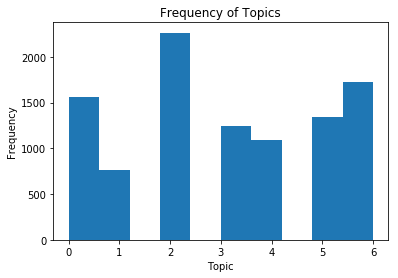

In [43]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
nmf_topic_historgram = df_small['nmf_topic_#'].plot(kind='hist',title='Frequency of Topics')
plt.xlabel('Topic')

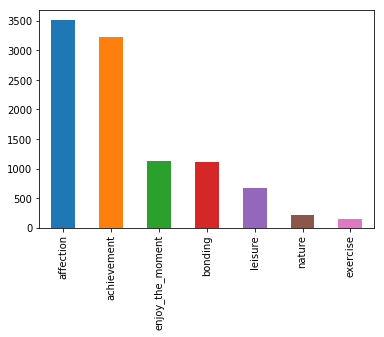

In [44]:
df_small['predicted_category'].value_counts().plot(kind='bar')

(<Figure size 432x288 with 3 Axes>,
 OrderedDict([(('affection', '1'),
               (0.0, 0.0, 0.340485436893204, 0.08330677580413404)),
              (('affection', '2'),
               (0.0,
                0.08657474966034318,
                0.340485436893204,
                0.17024773981448865)),
              (('affection', '3'),
               (0.0,
                0.26009046333104097,
                0.340485436893204,
                0.08470454049883423)),
              (('affection', '5'),
               (0.0,
                0.3480629776860844,
                0.340485436893204,
                0.17500013977646953)),
              (('affection', '4'),
               (0.0,
                0.526331091318763,
                0.340485436893204,
                0.058147011299529726)),
              (('affection', '6'),
               (0.0,
                0.5877460764745019,
                0.340485436893204,
                0.23007206874765876)),
              (('affection', 

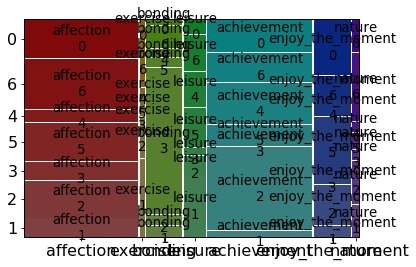

In [45]:
from statsmodels.graphics.mosaicplot import mosaic
plt.rcParams['font.size'] = 16.0
mosaic(df_small, ['predicted_category', 'nmf_topic_#'])

## The below catplot shows the relatoinship beteween our topic models and the predicted categories. 

## ASSUMING Predicted categories are correct, our model has hard time predicted nature and exercise. 

/Users/matthewvitha/anaconda/lib/python3.5/site-packages/seaborn/categorical.py:3692: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


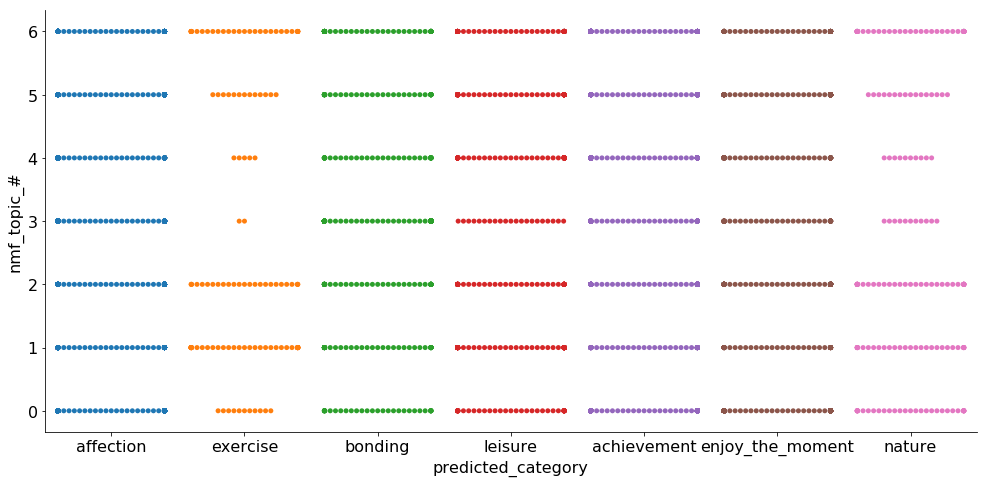

In [46]:
sns.catplot(x="predicted_category", y="nmf_topic_#",kind='swarm', data=df_small,size=7, aspect = 2)

## Above we have nmf model below. 

## to test if a different model will generate nicer results, we try to implement an LDA model. 

### note - a count_vectorizer is used compared to a TF_IDF vectorizer. 

#### Again - 7 topics used to match predicted categories. 

In [47]:
from __future__ import print_function
from gensim import corpora, models, similarities, matutils
from sklearn.cluster import KMeans

/Users/matthewvitha/anaconda/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [48]:
from sklearn.decomposition import LatentDirichletAllocation

In [49]:
from sklearn.feature_extraction.text import CountVectorizer
# LDA can only use raw term counts for LDA because it is a probabilistic graphical model

no_features = 1000

tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2, max_features=no_features, stop_words='english')
tf = tf_vectorizer.fit_transform(lemma_books)
tf_feature_names = tf_vectorizer.get_feature_names()

In [99]:
tf

<10000x1000 sparse matrix of type '<class 'numpy.int64'>'
	with 61140 stored elements in Compressed Sparse Row format>

In [50]:
no_topics = 7

lda = LatentDirichletAllocation(n_topics=no_topics, max_iter=5, learning_method='online', learning_offset=50.,random_state=0).fit(tf)

/Users/matthewvitha/anaconda/lib/python3.5/site-packages/sklearn/decomposition/online_lda.py:294: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)


In [51]:
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print(topic_idx)
        print([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]])

In [52]:
no_top_words = 7
display_topics(lda, tf_feature_names, no_top_words)

0
['getting', 'told', 'girlfriend', 'happiness', 'happy', 'completed', 'kid']
1
['dinner', 'favorite', 'husband', 'dog', 'received', 'good', 'watched']
2
['happy', 'got', 'work', 'day', 'able', 'moment', 'home']
3
['went', 'family', 'time', 'nice', 'enjoyed', 'long', 'place']
4
['new', 'got', 'happy', 'old', 'birthday', 'job', 'bought']
5
['great', 'like', 'happy', 'lunch', 'feel', 'life', 'going']
6
['friend', 'time', 'game', 'daughter', 'lot', 'got', 'happy']


## The below visualization is a nice representation of each topic. 

In [53]:
import pyLDAvis
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()
pyLDAvis.sklearn.prepare(lda, tf, tf_vectorizer)

/Users/matthewvitha/anaconda/lib/python3.5/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
2      21.548685        1       1  0.104602  0.098148
4      14.957557        1       2  0.105442  0.252255
6      14.916020        1       3  0.127998  0.022060
5      14.303295        1       4  0.019760  0.023820
3      12.856693        1       5  0.089165 -0.288299
1      12.433265        1       6 -0.044589 -0.161834
0       8.984484        1       7 -0.402379  0.053851, topic_info=     Category         Freq        Term        Total  loglift  logprob
term                                                                 
324   Default  1059.000000      friend  1059.000000  30.0000  30.0000
967   Default  1028.000000        went  1028.000000  29.0000  29.0000
568   Default   723.000000         new   723.000000  28.0000  28.0000
350   Default  1209.000000         got  1209.000000  27.0000  27.0000
223   Default   399.000000      dinner   399.000000  26.0000  26.0000
335   Default   301.000000     getting   301.000000  25.0000  25.0000
286   Default   438.000000      family   438.000000  24.0000  24.0000
291   Default   302.000000    favorite   302.000000  23.0000  23.0000
898   Default   955.000000        time   955.000000  22.0000  22.0000
415   Default   342.000000     husband   342.000000  21.0000  21.0000
230   Default   241.000000         dog   241.000000  20.0000  20.0000
582   Default   367.000000         old   367.000000  19.0000  19.0000
332   Default   258.000000        game   258.000000  18.0000  18.0000
980   Default   773.000000        work   773.000000  17.0000  17.0000
10    Default   470.000000        able   470.000000  16.0000  16.0000
901   Default   198.000000        told   198.000000  15.0000  15.0000
78    Default   253.000000    birthday   253.000000  14.0000  14.0000
440   Default   253.000000         job   253.000000  13.0000  13.0000
339   Default   190.000000  girlfriend   190.000000  12.0000  12.0000
481   Default   259.000000        like   259.000000  11.0000  11.0000
210   Default   376.000000    daughter   376.000000  10.0000  10.0000
359   Default   390.000000       great   390.000000   9.0000   9.0000
505   Default   227.000000       lunch   227.000000   8.0000   8.0000
690   Default   215.000000    received   215.000000   7.0000   7.0000
92    Default   233.000000      bought   233.000000   6.0000   6.0000
378   Default  2194.000000       happy  2194.000000   5.0000   5.0000
969   Default   273.000000        wife   273.000000   4.0000   4.0000
957   Default   197.000000     watched   197.000000   3.0000   3.0000
293   Default   342.000000        feel   342.000000   2.0000   2.0000
498   Default   284.000000         lot   284.000000   1.0000   1.0000
...       ...          ...         ...          ...      ...      ...
715    Topic7    61.842998    research    62.679060   2.3962  -4.5505
886    Topic7    61.709645        test    62.547594   2.3962  -4.5527
229    Topic7    59.302308      doctor    60.140861   2.3956  -4.5925
469    Topic7    57.346087     learned    58.181204   2.3952  -4.6260
589    Topic7    51.961861       order    52.796962   2.3937  -4.7246
145    Topic7    51.035018      church    51.872564   2.3934  -4.7426
137    Topic7    50.475766     chicken    51.310483   2.3933  -4.7537
362    Topic7    49.850898     grocery    50.685447   2.3931  -4.7661
650    Topic7    49.247086       price    50.081849   2.3929  -4.7783
760    Topic7    45.709189        send    46.558587   2.3913  -4.8528
36     Topic7    45.497726     arrived    46.349435   2.3911  -4.8575
734    Topic7    42.140363     running    42.987270   2.3898  -4.9341
667    Topic7    41.990224    purchase    42.893401   2.3884  -4.9377
482    Topic7    43.834310       liked    44.825197   2.3873  -4.8947
937    Topic7    34.810400     variety    35.646029   2.3859  -5.1252
207    Topic7    34.630144       daily    35.479793   2.3854  -5.1304
136    Topic7    33.758777      cheese   

### Below will attempt to create interactive T-SNE plot for LDA

In [87]:
import bokeh as bp
from sklearn.manifold import TSNE
import IPython.display
from IPython.core.display import display, HTML, Javascript

In [100]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(min_df=10,
                             max_features=180000,
                             tokenizer=tokenize,
                             ngram_range=(1, 2))

NameError: name 'tokenize' is not defined

In [96]:
tsne_model = TSNE(n_components=2, verbose=1, random_state=42, n_iter=500)

In [91]:
lda_model = LatentDirichletAllocation(n_components=7,
                                      learning_method='online',
                                      max_iter=20,
                                      random_state=42)

In [92]:
X_topics = lda_model.fit_transform(tf)

In [94]:
n_top_words = 10
topic_summaries = []

topic_word = lda_model.components_  # get the topic words
vocab = tf_vectorizer.get_feature_names()

for i, topic_dist in enumerate(topic_word):
    topic_words = np.array(vocab)[np.argsort(topic_dist)][:-(n_top_words+1):-1]
    topic_summaries.append(' '.join(topic_words))
    print('Topic {}: {}'.format(i, ' | '.join(topic_words)))

Topic 0: happy | feel | month | going | saw | received | moment | friend | old | year
Topic 1: went | daughter | day | nice | husband | morning | took | love | time | long
Topic 2: happy | finally | yesterday | work | felt | got | car | happiness | week | able
Topic 3: family | lunch | went | able | happy | watching | mother | dinner | parent | child
Topic 4: friend | time | night | game | dog | movie | happy | went | good | best
Topic 5: got | work | home | happy | good | hour | wife | dinner | son | girlfriend
Topic 6: new | got | favorite | job | happy | birthday | bought | yesterday | moment | house


In [97]:
tsne_lda = tsne_model.fit_transform(X_topics)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.011s...
[t-SNE] Computed neighbors for 10000 samples in 0.577s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 83.929672
[t-SNE] Error after 500 iterations: 1.287231


In [98]:
unnormalized = np.matrix(X_topics)
doc_topic = unnormalized/unnormalized.sum(axis=1)

lda_keys = []
for i, tweet in enumerate(combined_sample['item_description']):
    lda_keys += [doc_topic[i].argmax()]

lda_df = pd.DataFrame(tsne_lda, columns=['x','y'])
lda_df['description'] = combined_sample['item_description']
lda_df['category'] = combined_sample['general_cat']
lda_df['topic'] = lda_keys
lda_df['topic'] = lda_df['topic'].map(int)

NameError: name 'combined_sample' is not defined

## Following the LDA, I attempted to establish a word cloud from the corpus. 

## QUESTION - HOW CAN I MAKE A BETTER ONE? 

## HAVE SOME code that tries to only show the top words from the count vectorizer to make the world cloud less croweded...... but it didn't work.

In [54]:
from wordcloud import WordCloud, STOPWORDS 
import matplotlib.pyplot as plt 
from subprocess import check_output

In [55]:
type(df_small['cleaned_hm'])

pandas.core.series.Series

In [56]:
df_small_a = df_small

In [57]:
cleaned_hm_a = [str(i) for i in df_small_a['cleaned_hm']]

In [58]:
letters_only = re.sub("[^a-zA-Z]",  # Search for all non-letters
                          " ",          # Replace all non-letters with spaces
                          str(df_small_a['cleaned_hm']))

In [83]:
wordcloud = WordCloud(width = 20000, height = 2000, 
                background_color ='black',max_words=50,  
                min_font_size = 10).generate(letters_only)

In [84]:
import matplotlib.pyplot as plt

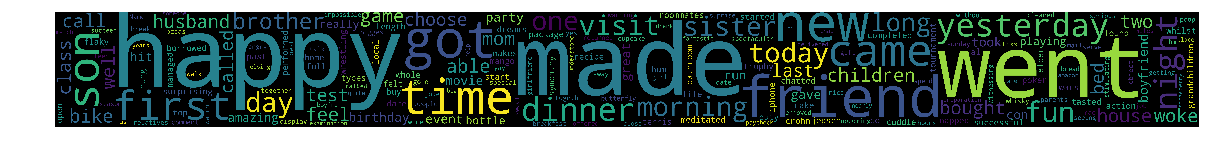

In [85]:
print(wordcloud)
fig = plt.figure(1)
fig.set_size_inches(20.5, 10.5)
#fig.savefig('test2png.png', dpi=100)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [69]:
dtm

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [70]:
n=30
vocab = np.array(vectorizer.get_feature_names())
tfidf_sorting = np.argsort(vocab.flatten()[::-1]

vocab[tfidf_sorting][:n]

SyntaxError: invalid syntax (<ipython-input-70-90cec65a5c3d>, line 5)

In [71]:
vocab

array(['00', '000', '00am', ..., 'zootopia', 'zumba', 'zverev'],
      dtype='<U17')

In [72]:
def top_tfidf_feats(row, features, top_n=25):
    ''' Get top n tfidf values in row and return them with their corresponding feature names.'''
    topn_ids = np.argsort(row)[::-1][:top_n]
    top_feats = [(features[i], row[i]) for i in topn_ids]
    df1 = pd.DataFrame(top_feats)
    df1.columns = ['feature', 'tfidf']
    return df1

In [73]:
tf.shape

(10000, 1000)

In [75]:
top_tfidf_feats(tf[1000:,], tf_feature_names, top_n=25)

,feature,tfidf
0,00,"(0, 702)\t1\n (0, 9)\t1\n (0, 265)\t1\n (..."


In [234]:
def top_feats_in_doc(dtm, features,top_n=25):
    row = np.squeeze(dtm[row_id].toarray())

    return top_tfidf_feats(row, features, top_n)

In [239]:
top_feats_in_doc(tf,tf_feature_names,top_n=25)

NameError: name 'row_id' is not defined

## Following LDA and NFM, I attempt to use a cluster analyis to see if it can create better comparisons between the HM's. 

### It seems to do alright, more clusters will do better. 


#### Also hope to ask for interpretation of the plot and clusters. 

In [76]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters = 10, n_init = 5, n_jobs = -1)
kmeans.fit(dtm)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=10, n_init=5, n_jobs=-1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [77]:
common_words = kmeans.cluster_centers_.argsort()[:,-1:-11:-1]
for num, centroid in enumerate(common_words):
    print(str(num) + ' : ' + ', '.join(vocab[word] for word in centroid))

0 : got, day, today, good, able, daughter, morning, son, happy, found
1 : work, got, day, home, today, happy, project, made, able, finished
2 : new, bought, got, car, job, purchased, happy, phone, house, buy
3 : made, happy, month, feel, past, today, day, yesterday, got, make
4 : last, night, week, sleep, happy, month, got, dinner, good, bed
5 : friend, old, best, met, seen, talked, birthday, got, school, lunch
6 : dinner, family, made, nice, ate, husband, went, parent, send, restaurant
7 : went, movie, shopping, temple, walk, friend, family, park, gym, long
8 : moment, happiest, life, happy, month, office, vocation, grandma, shared, future
9 : time, first, long, spend, friend, spent, got, happy, able, went


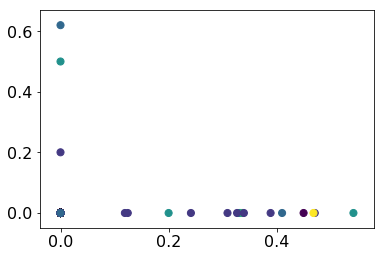

In [78]:
labels = KMeans(7, random_state=0).fit_predict(dtm)
plt.scatter(dtm[:, 0], dtm[:, 1],s=50, c=labels,cmap='viridis')

In [ ]:
# lda from the mercari interactive.. to try later 

In [1]:
from sklearn.decomposition import LatentDirichletAllocation

from sklearn.feature_extraction.text import CountVectorizer
# LDA can only use raw term counts for LDA because it is a probabilistic graphical model

no_features = 1000

cvectorizer = CountVectorizer(max_df=0.95, min_df=2, max_features=no_features, stop_words='english')
cvz = cvectorizer.fit_transform(lemma_books)
vocab1 = cvectorizer.get_feature_names()

no_topics = 13

lda_model = LatentDirichletAllocation(n_topics=no_topics, max_iter=5, learning_method='online', learning_offset=50.,random_state=0)

X_topics = lda_model.fit_transform(cvz)

n_top_words = 10
topic_summaries = []
topic_word = lda_model.components_ # get the topic words
vocab = cvectorizer.get_feature_names()
for i, topic_dist in enumerate(topic_word):
    topic_words = np.array(vocab)[np.argsort(topic_dist)][:-(n_top_words+1):-1]
    topic_summaries.append(' '.join(topic_words))
    print('Topic {}: {}'.format(i, ' | '.join(topic_words)))

tsne_lda = tsne_model.fit_transform(X_topics)

unnormalized = np.matrix(X_topics)
doc_topic = unnormalized/unnormalized.sum(axis=1)
lda_keys = []
for i in enumerate(np.array(lemma_books)):
    lda_keys += [doc_topic[i].argmax()]
    lda_df = pd.DataFrame(tsne_lda, columns=['x','y'])
    lda_df['description'] = combined_sample['item_description']
    lda_df['topic'] = lda_keys
    lda_df['topic'] = lda_df['topic'].map(int)

tsne_lda.view




/Users/matthewvitha/anaconda/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/matthewvitha/anaconda/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/matthewvitha/anaconda/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/matthewvitha/anaconda/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


NameError: name 'lemma_books' is not defined